In [31]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import ga_ml as ga

# Function

## Scaling

In [32]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    return input_values_scaled

## Fitness

In [33]:
def calculate_fitness(individual):

    N = individual[0]
    H = individual[1]
    # Define the model architecture
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=(3,)))  # Scalarization layer
    
    # Add hidden layers
    for _ in range(H):
        model.add(tf.keras.layers.Dense(N, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(6, activation='softplus'))  # Output layer with 6 neurons
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_absolute_error')

    # Train the model with given hyperparameters
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
    # Evaluate the model on validation data to compute the fitness value
    y_val_pred = model.predict(X_val)
    val_loss = mean_squared_error(y_val, y_val_pred)
    
    # Fitness value is the inverse of the validation loss (lower loss is better)
    fitness = 1 / (val_loss + 1e-10)  # Adding a small value to prevent division by zero
    
    return fitness


# Search N and H

In [34]:
# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter-1\dataset\simulation_results_new.csv")

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Apply custom scaling
X_scaled = custom_scaling(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Assuming you have already defined your machine learning model and dataset
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


In [35]:
# Define the general values for N
neuron_values = [16, 32, 64, 128, 256, 512]


# Define the range for H
H_min, H_max = 2, 8

mutation_ranges = [neuron_values,   # Possible values for N (number of neurons)
                   (H_min, H_max)]              # Range for H (number of layers)

# Define the size of the population
sol_per_pop = 8#12
num_parents_mating = 4
pop_size = (sol_per_pop, 2)  # We have 3 variables: N, C, fsw
num_generations = 5

# Generate random values for N and H
N_values = np.random.choice(neuron_values, size=(sol_per_pop, 1))  # Random N values
H_values = np.random.randint(H_min, H_max + 1, size=(sol_per_pop, 1))  # Random H values

# Combine N and H values into the initial population
initial_population = np.column_stack((N_values, H_values))

print(initial_population)



[[ 32   7]
 [512   3]
 [512   7]
 [128   8]
 [ 64   5]
 [ 32   6]
 [256   5]
 [ 32   6]]


## Genetic Algorithm

In [36]:

# Genetic Algorithm optimization
best_outputs = []
best_solutions = []  # Store the best solution for each generation
best_fitnesses = []  # Store the best fitness for each generation
new_population = initial_population

for generation in range(num_generations):
    print("Generation : ", generation)
    
    # Measuring the fitness of each chromosome in the population.
    fitness_values = []
    delta_IL_percent_values = []
    delta_Vo_percent_values = []
    for individual in new_population:
        fitness_value = calculate_fitness(individual)
        fitness_values.append(fitness_value)

    fitness = np.array(fitness_values)

    
    print("Fitness")
    print(fitness)

    best_outputs.append(np.min(fitness))
    print("Best result : ", np.min(fitness))

    # Find the index of the best solution in this generation
    best_solution_idx = np.argmin(fitness)
    best_solution = new_population[best_solution_idx]
    best_solutions.append(best_solution)
    best_fitness = fitness[best_solution_idx]
    best_fitnesses.append(best_fitness)
    print("Best solution : ", best_solution)
    print("Best fitness : ", best_fitness)

    # Selecting the best parents in the population for mating.
    parents = ga.select_mating_pool(new_population, fitness, num_parents_mating)
    print("Parents")
    print(parents)

    # Generating next generation using crossover.
    offspring_crossover = ga.crossover(parents, offspring_size=(pop_size[0]-parents.shape[0], 3))
    print("Crossover")
    print(offspring_crossover)

    # Adding some variations to the offspring using mutation.
    # offspring_mutation = ga.mutation(offspring_crossover, 2)
    offspring_mutation = ga.mutation(offspring_crossover, mutation_ranges, 1)
    print("Mutation")
    print(offspring_mutation)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

# Getting the best solution after iterating finishing all generations.
# At first, the fitness is calculated for each solution in the final generation.
fitness_values = []

for individual in new_population:
    fitness_value= calculate_fitness(individual)
    fitness_values.append(fitness_value)

fitness = np.array(fitness_values)


# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.min(fitness))

print("Best solution : ", new_population[best_match_idx, :])
print("Best solution fitness : ", fitness[best_match_idx])


plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()

Generation :  0
Epoch 1/100, Loss: 0.7544298768043518, Val Loss: 0.44074857234954834
Epoch 2/100, Loss: 0.44530659914016724, Val Loss: 0.3406551480293274
Epoch 3/100, Loss: 0.3852047622203827, Val Loss: 0.30399593710899353
Epoch 4/100, Loss: 0.34886518120765686, Val Loss: 0.2627183794975281
Epoch 5/100, Loss: 0.31506162881851196, Val Loss: 0.24494072794914246
Epoch 6/100, Loss: 0.2823949456214905, Val Loss: 0.22520685195922852
Epoch 7/100, Loss: 0.27202078700065613, Val Loss: 0.1980844885110855
Epoch 8/100, Loss: 0.2573493421077728, Val Loss: 0.17867957055568695
Epoch 9/100, Loss: 0.2481323927640915, Val Loss: 0.1707584112882614
Epoch 10/100, Loss: 0.2423565685749054, Val Loss: 0.1746949404478073
Epoch 11/100, Loss: 0.23595945537090302, Val Loss: 0.15342150628566742
Restoring model weights from the end of the best epoch: 6.
Epoch 11: early stopping
127/127 [==============================] - 0s 610us/step
Epoch 1/100, Loss: 0.9589999914169312, Val Loss: 0.49539080262184143
Epoch 2/100, 

NameError: name 'mutation_ranges' is not defined

# Machine Learning

Epoch 1/50
175/175 [==============================] - 1s 2ms/step - loss: 1.2312 - val_loss: 1.8220
Epoch 2/50
175/175 [==============================] - 0s 1ms/step - loss: 0.7014 - val_loss: 0.9146
Epoch 3/50
175/175 [==============================] - 0s 1ms/step - loss: 0.5161 - val_loss: 0.4631
Epoch 4/50
175/175 [==============================] - 0s 1ms/step - loss: 0.4439 - val_loss: 0.3551
Epoch 5/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3981 - val_loss: 0.2742
Epoch 6/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3696 - val_loss: 0.2336
Epoch 7/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3615 - val_loss: 0.2677
Epoch 8/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3536 - val_loss: 0.2804
Epoch 9/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3828 - val_loss: 0.2224
Epoch 10/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3367 - val_loss: 0.2040

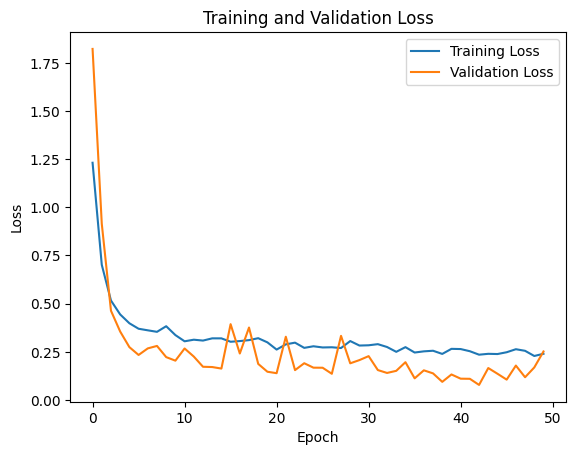

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\modified_8000_dataset.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Scale input features to range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 1
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),         
    tf.keras.layers.Dense(6, activation='softplus')                               # Output layer with 6 neurons
])

# model = tf.keras.Sequential([
#     tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 1
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),         
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),         
#     tf.keras.layers.Dense(6, activation='softplus')                               # Output layer with 6 neurons
# ])


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with custom callback to print information at the end of each epoch
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[PrintEpochInfo()], verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing Set

In [7]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

38/38 [==============================] - 0s 606us/step - loss: 0.1632
Mean Squared Error on Testing Set: 0.16320562362670898
38/38 [==============================] - 0s 499us/step
Predictions:
[[0.20654827 6.483947   2.6345077  2.6322153  0.01708872 1.3133281 ]
 [0.12445674 4.282261   3.5189834  3.520649   0.00829306 1.0214925 ]
 [0.14707306 6.546033   3.3875675  3.4100778  0.00850959 1.2893308 ]
 [0.06795892 4.3753366  2.3814638  2.3742485  0.01889426 2.3163981 ]
 [0.06067272 0.20301414 2.079679   2.104424   0.14704187 2.053334  ]]
True Values:
[[0.26001435 4.23264405 2.74299141 2.74299141 0.01217656 1.29224261]
 [0.19503469 3.32206237 3.59940991 3.59940991 0.00902757 0.95760415]
 [0.23933468 4.23420079 3.51435724 3.51435724 0.00733677 1.291914  ]
 [0.08042573 4.24613856 2.40471154 2.40471154 0.02217949 2.34150863]
 [0.07897327 0.58997409 2.02413572 2.02413572 0.16765618 2.15456352]]
Mean Absolute Error (MAE): 0.13914263041641098
Root Mean Squared Error (RMSE): 0.4039871578126952
R-sq

## Save Model

In [ ]:
# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Optionally, save the model
model.save("ripples_prediction_model.h5")


# COba

In [5]:
import numpy as np

# Define the general values for N
neuron_values = [16, 32, 64, 128, 256, 512]

# Define the range for H
H_min, H_max = 2, 8

# Define the size of the population
sol_per_pop = 12
pop_size = (sol_per_pop, 3)  # We have 3 variables: N, C, fsw

# Generate random values for N and H
N_values = np.random.choice(neuron_values, size=(sol_per_pop, 1))  # Random N values
H_values = np.random.randint(H_min, H_max + 1, size=(sol_per_pop, 1))  # Random H values

# Combine N and H values into the initial population
initial_population = np.column_stack((N_values, H_values))

print("Initial Population (before replacing):")
print(initial_population)

# Now let's say you generate new N and H values
# For demonstration, I'm just regenerating the same values, but in practice, these would be generated differently
new_N_values = np.random.choice(neuron_values, size=(sol_per_pop, 1))  # New random N values
new_H_values = np.random.randint(H_min, H_max + 1, size=(sol_per_pop, 1))  # New random H values

# Replace the existing N and H values in the initial population with the new ones
initial_population[:, :2] = np.column_stack((new_N_values, new_H_values))

print("\nInitial Population (after replacing N and H):")
print(initial_population)


Initial Population (before replacing):
[[ 32   6]
 [128   6]
 [ 64   2]
 [512   8]
 [ 16   2]
 [128   8]
 [ 64   8]
 [256   5]
 [ 64   3]
 [ 64   7]
 [ 16   6]
 [512   7]]

Initial Population (after replacing N and H):
[[ 16   6]
 [128   5]
 [ 32   5]
 [ 16   7]
 [ 16   2]
 [512   4]
 [ 64   5]
 [ 32   8]
 [ 16   2]
 [128   3]
 [512   4]
 [256   3]]


In [8]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    return input_values_scaled

In [13]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error


# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"E:\ai-power-converter\dataset\simulation_results_new.csv")

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Apply custom scaling
X_scaled = custom_scaling(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Assuming you have already defined your machine learning model and dataset
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")

def compute_fitness(N, H):
    # Define the model architecture
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=(3,)))  # Scalarization layer
    
    # Add hidden layers
    for _ in range(H):
        model.add(tf.keras.layers.Dense(N, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(6, activation='softplus'))  # Output layer with 6 neurons
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_absolute_error')

    # Train the model with given hyperparameters
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
    # Evaluate the model on validation data to compute the fitness value
    y_val_pred = model.predict(X_val)
    val_loss = mean_squared_error(y_val, y_val_pred)
    
    # Fitness value is the inverse of the validation loss (lower loss is better)
    fitness = 1 / (val_loss + 1e-10)  # Adding a small value to prevent division by zero
    
    return fitness

# Example initial population
initial_population = np.array([[32, 2],
                               [64, 3],
                               [128, 4]])

# Compute fitness values for each individual in the initial population
fitness_values = np.zeros(initial_population.shape[0])
for i in range(initial_population.shape[0]):
    N = initial_population[i, 0]
    H = initial_population[i, 1]
    fitness_values[i] = compute_fitness(N, H)

print("Fitness Values:")
print(fitness_values)


Epoch 1/100, Loss: 0.6268067955970764, Val Loss: 0.28709328174591064
Epoch 2/100, Loss: 0.30734753608703613, Val Loss: 0.23412251472473145
Epoch 3/100, Loss: 0.2656424641609192, Val Loss: 0.19972191751003265
Epoch 4/100, Loss: 0.2500516474246979, Val Loss: 0.1918286830186844
Epoch 5/100, Loss: 0.24158038198947906, Val Loss: 0.19080698490142822
Epoch 6/100, Loss: 0.2319944053888321, Val Loss: 0.16897359490394592
Epoch 7/100, Loss: 0.2259361296892166, Val Loss: 0.15812624990940094
Epoch 8/100, Loss: 0.2241038829088211, Val Loss: 0.16767439246177673
Epoch 9/100, Loss: 0.21949326992034912, Val Loss: 0.15066780149936676
Epoch 10/100, Loss: 0.21718266606330872, Val Loss: 0.1523561030626297
Epoch 11/100, Loss: 0.21554400026798248, Val Loss: 0.14291980862617493
Restoring model weights from the end of the best epoch: 6.
Epoch 11: early stopping
127/127 [==============================] - 1s 3ms/step
Epoch 1/100, Loss: 0.6204947829246521, Val Loss: 0.35535943508148193
Epoch 2/100, Loss: 0.3491800

In [4]:
def mutation(offspring_crossover, mutation_ranges, num_mutations=1):
    mutated_offspring = np.copy(offspring_crossover)
    num_genes = mutated_offspring.shape[1]
    
    # Mutation for N (number of neurons)
    for idx in range(mutated_offspring.shape[0]):  # Iterate over each individual in the population
        # Mutation for N: randomly select a value from the provided range
        mutated_N = np.random.choice(mutation_ranges[0])
        mutated_offspring[idx, 0] = mutated_N
    
    # Mutation for H (number of layers)
    for idx in range(mutated_offspring.shape[0]):  # Iterate over each individual in the population
        # Mutation for H: randomly increment or decrement H by 1
        mutation_value_H = np.random.choice([-1, 1])
        mutated_H = mutated_offspring[idx, 1] + mutation_value_H
        
        # Ensure the mutated value of H remains within the provided range
        mutated_H = np.clip(mutated_H, min(mutation_ranges[1]), max(mutation_ranges[1]))
        mutated_offspring[idx, 1] = mutated_H
    
    return mutated_offspring


In [89]:
import numpy as np

offspring_crossover = np.array([[32, 3],   # Sample individual 1: N=32, H=3
                                [64, 6],   # Sample individual 2: N=64, H=6
                                [128, 2],  # Sample individual 3: N=128, H=2
                                [16, 4],   # Sample individual 4: N=16, H=4
                                [32, 7],   # Sample individual 5: N=32, H=7
                                [64, 3],   # Sample individual 6: N=64, H=3
                                [64, 5],   # Sample individual 7: N=64, H=5
                                [128, 2],  # Sample individual 8: N=128, H=2
                                [32, 6],   # Sample individual 9: N=32, H=6
                                [128, 3],  # Sample individual 10: N=128, H=3
                                [64, 8],   # Sample individual 11: N=64, H=8
                                [32, 4]])  # Sample individual 12: N=32, H=4


# Define mutation ranges for N and H
mutation_ranges = [[16, 32, 64, 128],   # Possible values for N (number of neurons)
                   (2, 8)]              # Range for H (number of layers)



# Number of mutations to perform
num_mutations = 1

# Function call to perform mutation
mutated_offspring = mutation(offspring_crossover, mutation_ranges, num_mutations)

# Display mutated offspring
print("Mutated Offspring:")
print(mutated_offspring)


Mutated Offspring:
[[ 64   2]
 [ 64   7]
 [ 16   3]
 [ 64   5]
 [ 32   8]
 [ 64   4]
 [ 16   6]
 [128   2]
 [128   5]
 [ 32   2]
 [128   7]
 [128   3]]
